In [1]:
import pandas as pd
import torch
import torch.nn as nn
from normalization import Input_output_data

df = pd.read_csv('Irregular-subnet/MSD/MSD_linear_noiseless_k_020.csv')

# Extract data
u = torch.tensor(df['Input'].values, dtype=torch.float32).view(-1, 1)  
y = torch.tensor(df['Output'].values, dtype=torch.float32).view(-1, 1)  
delta_t = torch.tensor(df['Delta_t'].values, dtype=torch.float32).view(-1, 1)  

# For test below
state_cols = [c for c in df.columns if c.startswith('TrueState_')]
x = torch.tensor(df[state_cols].values, dtype=torch.float32)   # (N , nx)

print(u.shape, y.shape, delta_t.shape, x.shape)  
data = Input_output_data(u, y, delta_t, x=x, name='irregular_sampling')

# Split dataset
train, val, test  = data[:5000], data[5000:6000], data[6000:]

print(f'{train = }')
print(f'{val = }')
print(f'{test = }')



torch.Size([10000, 1]) torch.Size([10000, 1]) torch.Size([10000, 1]) torch.Size([10000, 2])
train = Input_output_data "irregular_sampling" u.shape=torch.Size([5000, 1]), y.shape=torch.Size([5000, 1]), sampling_time varying, length=5000
val = Input_output_data "irregular_sampling" u.shape=torch.Size([1000, 1]), y.shape=torch.Size([1000, 1]), sampling_time varying, length=1000
test = Input_output_data "irregular_sampling" u.shape=torch.Size([4000, 1]), y.shape=torch.Size([4000, 1]), sampling_time varying, length=4000


In [2]:
std_delta_t = torch.std(delta_t)
var_delta_t = torch.var(delta_t)

print(f"Standard deviation of Delta_t: {std_delta_t.item()}")
print(f"Variance of Delta_t: {var_delta_t.item()}")


Standard deviation of Delta_t: 0.18383097648620605
Variance of Delta_t: 0.03379382938146591


Number of samples to train on = 4946


  0%|          | 0/30000 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val nan   nan samps/sec
it     100 NRMS loss 1.88693 NRMS val 0.85151!! 263.24 samps/sec
it     200 NRMS loss 0.77939 NRMS val 0.79128!! 264.39 samps/sec
it     300 NRMS loss 0.62650 NRMS val 0.23248!! 264.01 samps/sec
it     400 NRMS loss 0.30935 NRMS val 0.15454!! 264.30 samps/sec
it     500 NRMS loss 0.23063 NRMS val 0.09565!! 264.31 samps/sec
it     600 NRMS loss 0.18973 NRMS val 0.06152!! 263.64 samps/sec
it     700 NRMS loss 0.17758 NRMS val 0.05306!! 262.80 samps/sec
it     800 NRMS loss 0.17103 NRMS val 0.04336!! 262.48 samps/sec
it     900 NRMS loss 0.16379 NRMS val 0.03732!! 262.30 samps/sec
it   1,000 NRMS loss 0.16207 NRMS val 0.03312!! 262.08 samps/sec
it   1,100 NRMS loss 0.15777 NRMS val 0.03394   261.85 samps/sec
it   1,200 NRMS loss 0.15641 NRMS val 0.03542   261.72 samps/sec
it   1,300 NRMS loss 0.15122 NRMS val 0.02873!! 261.59 samps/sec
it   1,400 NRMS loss 0.15146 NRMS val 0.03127   261.49 samps/sec
it   1,500 NRMS loss 0.14746 NRMS va

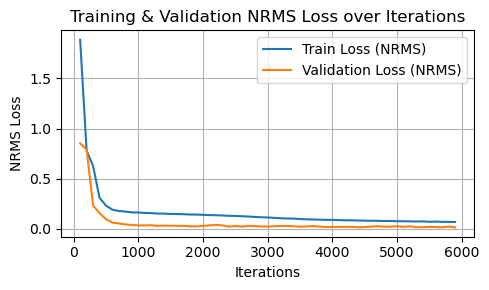

In [3]:

from normalization import get_nu_ny_and_auto_norm
from models import SUBNET_ISTS
from networks import rk4_integrator

nu, ny, norm = get_nu_ny_and_auto_norm(train)

torch.manual_seed(1)
model = SUBNET_ISTS(nu, ny, norm, nx=2, na=5, nb=5, integrator=rk4_integrator)
from fitting import fit
train_dict = fit(model, train=train, val=val, n_its=30000, T=50, batch_size=64, val_freq=100)


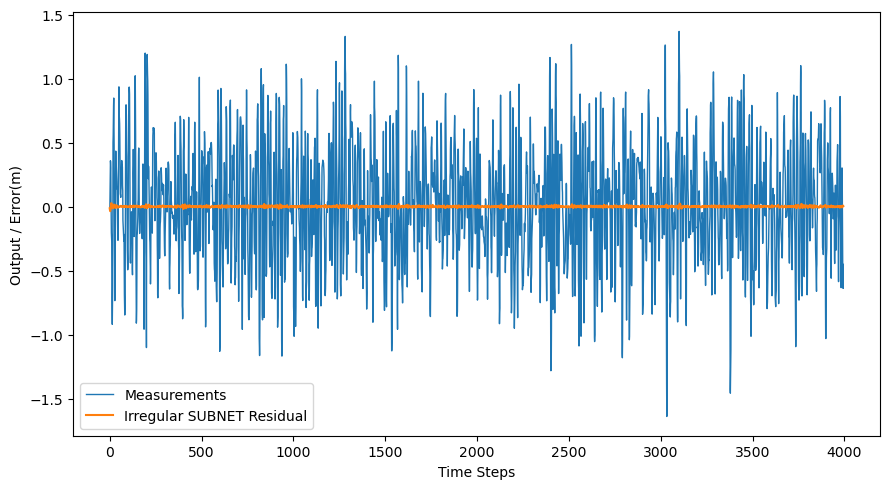

NRMS = 1.23%
RMSE = 0.0055 m


In [4]:
from matplotlib import pyplot as plt

test_sim = model.simulate(test)
y_true = test.y[model.na:]
y_pred = test_sim.y[model.na:]

if hasattr(y_true, 'detach'):
    y_true = y_true.detach().cpu().numpy()
if hasattr(y_pred, 'detach'):
    y_pred = y_pred.detach().cpu().numpy()

residual = y_true - y_pred

plt.figure(figsize=(9, 5))
# plt.plot(y_pred, label='Irregular SUBNET model',linewidth=1.5)
plt.plot(y_true, label='Measurements', linewidth=1)
plt.plot(residual, label='Irregular SUBNET Residual', linewidth=1.5)

# plt.title('True vs Predicted with Residual')
plt.xlabel('Time Steps')
plt.ylabel('Output / Error(m)')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

# Metric
from nonlinear_benchmarks.error_metrics import NRMSE, RMSE
print(f'NRMS = {NRMSE(y_true, y_pred)[0]:.2%}')
print(f'RMSE = {RMSE(y_true, y_pred)[0]:.4f} m')


### Test on equidistantly sampled time series

In [5]:
df = pd.read_csv('/Users/bloodytaken/graduate_project/data/MSD_linear_noiseless_k_000.csv')
# Extract data
u = torch.tensor(df['Input'].values, dtype=torch.float32).view(-1, 1)  
y = torch.tensor(df['Output'].values, dtype=torch.float32).view(-1, 1)  
delta_t = torch.tensor(df['Delta_t'].values, dtype=torch.float32).view(-1, 1)  
# delta_t = torch.cat([delta_t[1:], torch.tensor([[0.0]])], dim=0) # shift one step
# data = Input_output_data(u, y, delta_t, name='irregular_sampling')

# For test below
state_cols = [c for c in df.columns if c.startswith('TrueState_')]
x = torch.tensor(df[state_cols].values, dtype=torch.float32)   # (N , nx)

print(u.shape, y.shape, delta_t.shape, x.shape)   #  sanity-check：首维相同
data = Input_output_data(u, y, delta_t, x=x, name='irregular_sampling')

# Split dataset
test  =data[6000:]

torch.Size([10000, 1]) torch.Size([10000, 1]) torch.Size([10000, 1]) torch.Size([10000, 2])


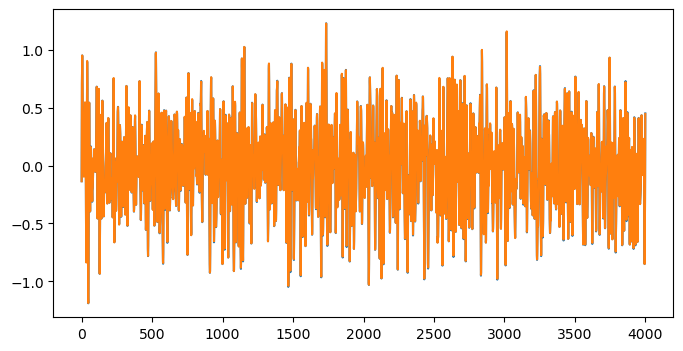

NRMS = 1.38%
RMSE = 0.0051 m


In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,4))
test_sim = model.simulate(test)

y_true = test.y[model.na:]
y_pred = test_sim.y[model.na:]
# residuals = y_true - y_pred
if hasattr(y_true, 'detach'):
    y_true = y_true.detach().cpu().numpy()
if hasattr(y_pred, 'detach'):
    y_pred = y_pred.detach().cpu().numpy() # convert to numpy format

plt.plot(test_sim.y) #simulate is apply_experiment equivilent
plt.plot(test.y)
plt.show()
from nonlinear_benchmarks.error_metrics import NRMSE, RMSE
# print(f'NRMS={NRMSE(test.y[model.na:], test_sim.y[model.na:]):.2%}')
# print(f'RMSE={RMSE(test.y[model.na:], test_sim.y[model.na:]):.4f} V')


print(f'NRMS = {NRMSE(y_true, y_pred)[0]:.2%}')
print(f'RMSE = {RMSE(y_true, y_pred)[0]:.4f} m')


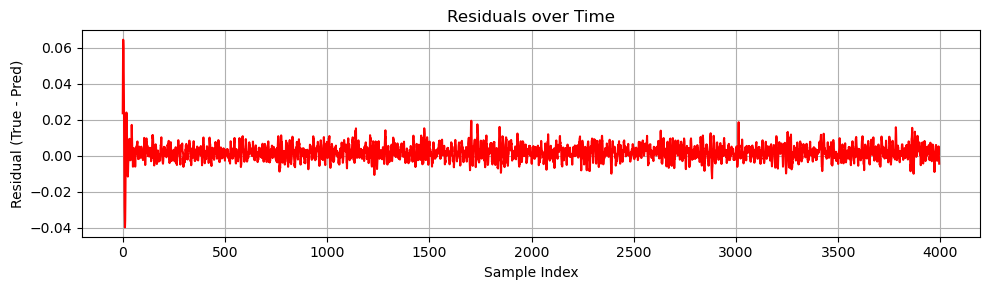

In [7]:
residuals = y_true - y_pred
plt.figure(figsize=(10, 3))
plt.plot(residuals, color='red')
plt.title('Residuals over Time')
plt.xlabel('Sample Index')
plt.ylabel('Residual (True - Pred)')
plt.grid(True)
plt.tight_layout()
plt.show()


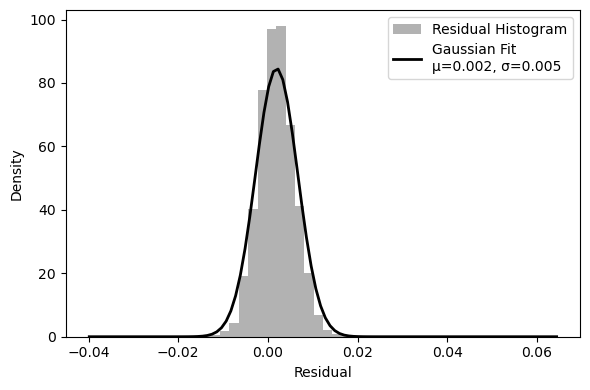

In [8]:
import numpy as np
from scipy.stats import norm

mu, sigma = norm.fit(residuals)
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, density=True, alpha=0.6, color='gray', label='Residual Histogram')
x_vals = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(x_vals, norm.pdf(x_vals, mu, sigma), 'k', linewidth=2, label=f'Gaussian Fit\nμ={mu:.3f}, σ={sigma:.3f}')
# plt.title('Residual Histogram with Gaussian Fit')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()
